#NLP - Sentiment Analysis Hotel based on Review with Comparing Naive Bayes and SVM


In [1]:
#import library

import numpy as np
#import pandas
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import classification_report, confusion_matrix
#import Natural Language Toolkit
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


#Data Facts and Import

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [4]:

rcParams['figure.figsize'] = 10, 10

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
#import data
corpus = pd.read_csv("/content/drive/MyDrive/PROYEK/Proyek PBA/7282_1.csv")

In [7]:
#Check the shape (number of columns and rows) in the dataset
corpus.shape

(35912, 19)

In [8]:
print('Panjang Corpus : ',len(corpus))

Panjang Corpus :  35912


In [9]:
#Show data
corpus

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews_date,reviews_dateAdded,reviews_doRecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,reviews_userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-20T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC
35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-12T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC
35909,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2015-11-03T00:00:00Z,2016-06-23T16:50:58Z,NaN,NaN,5.0,My husband and I stayed at Tree Tops which is ...,Amazing time (both times!!),Charlotte,Carol W.,NC
35910,3747 29th St S E,"Hotels-Apartment,Corporate Lodging,Hotels,Lodging",Grand Rapids,US,42.909480,-85.573590,Extended Stay America Grand Rapids - Kentwood,49512,MI,NaN,2015-12-01T19:40:54Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN


In [10]:
#Show 5 random of rows
corpus.sample(5)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews_date,reviews_dateAdded,reviews_doRecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,reviews_userProvince
11107,301 Reserve Ave,"Luxury Hotels,Restaurants,Hotels & Motels,Lodg...",Roanoke,US,37.256149,-79.947005,Cambria Hotel & Suites,24016,VA,2015-10-26T00:00:00Z,2016-10-13T13:22:03Z,NaN,NaN,5.0,This upscale Choice property was perfect for o...,Base for Roanoke visit,Tucson,Paul G,AZ
29089,355 Santana Row,"Hotels,Hotel, Bar, and Hotel Bar",San Jose,US,37.320980,-121.947900,Hotel Valencia Santana Row,95128,CA,2015-12-26T00:00:00Z,2016-11-17T15:13:00Z,NaN,NaN,3.0,I've stayed two nights for a business trip at ...,"Good location, large rooms, but old bathroom",The Netherlands,Joris L,MI
15961,2120 Claude Bailey Pkwy,"Travel & Transport,Hotels & Motels",Princeton,US,41.368016,-89.456966,Americinn Lodge Suites Princeton,61356,IL,2016-03-21T00:00:00Z,2017-01-08T18:34:34Z,NaN,NaN,1.0,From the warm greeting at check-in to the serv...,overall Very satisfied,Lewistown,Kenneth N,NaN
13555,19 Sombrero Blvd,Hotels,Marathon,US,24.711823,-81.080550,Sombrero Resort and Marina,33050,Grassy Key,2016-01-23T00:00:00Z,2016-11-05T19:13:20Z,NaN,NaN,2.0,Hotel is old. This might be section due to be ...,Avoid in current condition!,Boca Raton,H.Chris,FL
9008,2512 W Lincolnway,Hotels,Cheyenne,US,41.119150,-104.849490,Americas Best Value Inn,82001,WY,2016-07-24T00:00:00Z,2016-11-21T23:27:41Z,NaN,NaN,3.0,"Not the nicest motel in the world, but it was ...",Good value for the money,NaN,A Traveler,NaN


In [11]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               35912 non-null  object 
 1   categories            35912 non-null  object 
 2   city                  35912 non-null  object 
 3   country               35912 non-null  object 
 4   latitude              35826 non-null  float64
 5   longitude             35826 non-null  float64
 6   name                  35912 non-null  object 
 7   postalCode            35857 non-null  object 
 8   province              35912 non-null  object 
 9   reviews_date          35653 non-null  object 
 10  reviews_dateAdded     35912 non-null  object 
 11  reviews_doRecommend   0 non-null      float64
 12  reviews_id            0 non-null      float64
 13  reviews_rating        35050 non-null  float64
 14  reviews_text          35890 non-null  object 
 15  reviews_title      

In [12]:
#display descriptive statistics
corpus.describe()

,latitude,longitude,reviews_doRecommend,reviews_id,reviews_rating
count,35826.000000,35826.000000,0.0,0.0,35050.000000
mean,37.285008,-85.725758,NaN,NaN,3.776431
std,6.996544,33.062263,NaN,NaN,1.416195
min,-25.436750,-166.559040,NaN,NaN,0.000000
25%,33.827340,-104.868200,NaN,NaN,3.000000
50%,37.936026,-86.822972,NaN,NaN,4.000000
75%,41.672491,-77.044550,NaN,NaN,5.000000
max,63.877674,115.164407,NaN,NaN,10.000000


In [13]:
print('Mean of hotel reviews: ', round(corpus['reviews_rating'].mean()))

Mean of hotel reviews:  4


#Exploratory Data Analysis

Column Handling

In [14]:
#Check for missing values in the dataset
corpus.isnull().sum(axis=0)

address                     0
categories                  0
city                        0
country                     0
latitude                   86
longitude                  86
name                        0
postalCode                 55
province                    0
reviews_date              259
reviews_dateAdded           0
reviews_doRecommend     35912
reviews_id              35912
reviews_rating            862
reviews_text               22
reviews_title            1622
reviews_userCity        19649
reviews_username           43
reviews_userProvince    18394
dtype: int64

In [15]:
#Checking Missing value in the dataset and printing the percentage for missing value for each column
count = corpus.isnull().sum().sort_values(ascending=False)
percentage = (corpus.isnull().sum()/corpus.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys=['Count', 'Percentage'])

print('Count and percentage of missing value for the columns:')
missing_data['Percentage']=missing_data['Percentage'].apply(lambda x: x*100)
missing_data.loc[missing_data['Percentage'] > 10][:10]


Count and percentage of missing value for the columns:


,Count,Percentage
reviews_id,35912,100.000000
reviews_doRecommend,35912,100.000000
reviews_userCity,19649,54.714302
reviews_userProvince,18394,51.219648


In [16]:
for i in range(0,len(corpus)-1):
    if type(corpus.iloc[i]['reviews_text']) != str:
        corpus.iloc[i]['reviews_text'] = str(corpus.iloc[i]['reviews_text'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
corpus = corpus[corpus['reviews_rating'] != 3]
corpus.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews_date,reviews_dateAdded,reviews_doRecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,reviews_userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [18]:
#labeling data
def sentiment(n):
    return 'positive' if n >= 4 else 'negative'
corpus['response'] = corpus['reviews_rating'].apply(sentiment)
corpus.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews_date,reviews_dateAdded,reviews_doRecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,reviews_userProvince,response
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,positive
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,positive
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,positive
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,positive
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,positive


In [19]:
corpus.sample(10)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews_date,reviews_dateAdded,reviews_doRecommend,reviews_id,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_username,reviews_userProvince,response
25413,4420 Cleburne Blvd,Hotels,Dublin,US,37.072560,-80.696850,Hampton Inn Dublin,24084,VA,2013-03-25T00:00:00Z,2016-11-11T17:16:59Z,NaN,NaN,1.0,the gps is wrong... follow the sign when you f...,Great place is tyou enjoy smoking!,Harpers Ferry,Kyla Lacey,NY,negative
1568,442 Walker Bay Blvd,Hotels,Walker,US,47.091240,-94.571720,Country Inn Walker,56484,Onigum,2016-02-15T00:00:00Z,2016-11-06T18:29:10Z,NaN,NaN,4.0,Our room was on the highway side (non-lakeside...,Pleasantly Suprised,Minneapolis,797alissaj,MN,positive
22524,4260 Broadway,"Family-Friendly Hotels,Hotels & Motels,Budget ...",Eureka,US,40.767605,-124.191895,Comfort Inn Humboldt Bay,95503-5738,CA,2016-11-30T00:00:00Z,2017-04-15T13:53:49Z,NaN,NaN,NaN,This hotel is recently renovated and looks com...,Its own little oasis!,Glendale,Brandy C,AZ,negative
12977,101 Lakeway Dr,Hotels,Austin,US,30.373974,-97.986940,Lakeway Resort & Spa,78734,Lakeway,2016-06-04T00:00:00Z,2016-10-30T18:52:22Z,NaN,NaN,4.0,Pillows are lumpy with stuffing stuck together...,Bad sleep,NaN,Kristin,NaN,positive
3185,2725 1st Ave,Hotels,Spearfish,US,44.480470,-103.813890,Quality Inn Spearfish,57783,SD,2015-09-26T00:00:00Z,2016-10-26T02:37:31Z,NaN,NaN,5.0,THIS WAS A STOP ON THE WAY HOME. STAY IN SPEAR...,A SPOT ON THE WAY HOME.,NaN,A Traveler,NaN,positive
12369,7070 Poe Ave,Hotels,Dayton,US,39.849845,-84.189419,Hawthorn Suites Dayton North,45414,OH,2015-06-24T00:00:00Z,2016-11-05T19:37:35Z,NaN,NaN,1.0,Very outdated room. Carpet was in very bad sha...,Very Rough Shape.,NaN,Michael,NaN,negative
31608,7500 N Point Pkwy,"Hotels,Hotel",Alpharetta,US,34.041713,-84.303592,Hyatt Place Atlanta/alpharetta/north Point Mall,30022,GA,2012-06-26T00:00:00Z,2016-11-15T20:53:10Z,NaN,NaN,4.0,"Life Fitness equipment... one bike, two treadm...",Clean and quite,NaN,Steve Owens,NaN,positive
34957,3024 Tv Rd,"Hotels,Lodging,Motels",Florence,US,34.265740,-79.731340,Americas Best Value Inn,29501-0710,SC,2014-10-25T00:00:00Z,2016-10-27T18:06:48Z,NaN,NaN,1.0,"The representative at Hotels.com said, This is...",Never Again!,Waterloo,Mrs. Lee,NY,negative
26210,4711 N Elizabeth,Hotels,Pueblo,US,38.321480,-104.618378,Wingate By Wyndham Pueblo,81008,CO,2016-06-14T00:00:00Z,2016-10-30T21:43:42Z,NaN,NaN,5.0,This hotel was very comfortable especially our...,Awesome Hotel,NaN,A Traveler,NaN,positive
26225,4711 N Elizabeth,Hotels,Pueblo,US,38.321480,-104.618378,Wingate By Wyndham Pueblo,81008,CO,2016-04-17T00:00:00Z,2016-10-30T21:43:42Z,NaN,NaN,5.0,Brandon at the front desk is wonderful. He was...,Bring your own pillow.,Aurora,A Traveler,CO,positive


In [20]:
corpus[['reviews_text','reviews_rating','response']]

,reviews_text,reviews_rating,response
0,Pleasant 10 min walk along the sea front to th...,4.0,positive
1,Really lovely hotel. Stayed on the very top fl...,5.0,positive
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0,positive
3,We stayed here for four nights in October. The...,5.0,positive
4,We stayed here for four nights in October. The...,5.0,positive
...,...,...,...
35907,Best of the Best!!!! My family and I stayed in...,5.0,positive
35908,Amazing Vacation in Beautiful Cabin We stayed ...,5.0,positive
35909,My husband and I stayed at Tree Tops which is ...,5.0,positive
35910,to share your opinion of this businesswith YP ...,0.0,negative


In [21]:
review_positif = len([x for x in corpus['response'] if x == 'positive'])
review_negatif = len([x for x in corpus['response'] if x == 'negative'])
print('Positive Reviews : ',review_positif)
print('Negative Reviews : ',review_negatif)

Positive Reviews :  22908
Negative Reviews :  7296


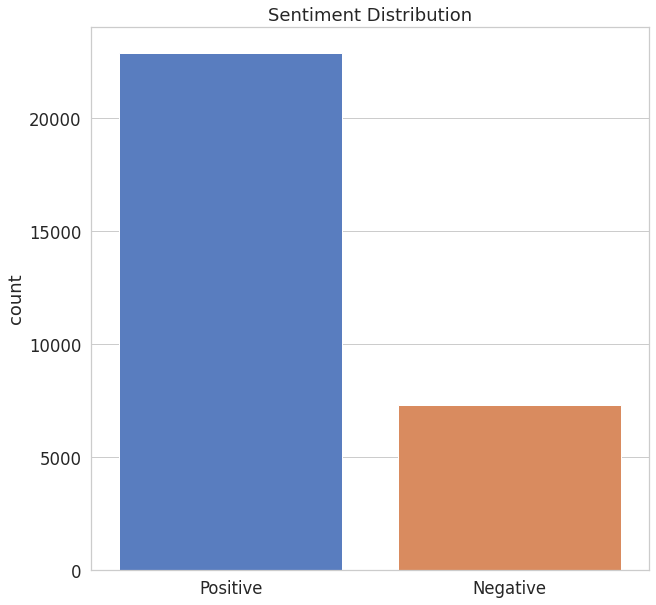

In [22]:
#show the sentiment distribution
f = sns.countplot(x='response', data=corpus)
f.set_title("Sentiment Distribution")
f.set_xticklabels(['Positive', 'Negative'])
plt.xlabel("");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Positive and Negative distribution in the data')

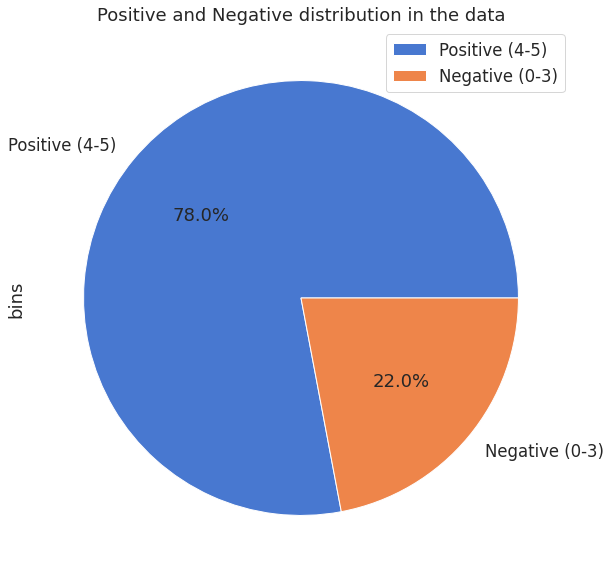

In [24]:
corpus['bins'] = pd.cut(corpus['reviews_rating'], bins=[-1,2,5], labels=['Negative (0-3)','Positive (4-5)'], right=True)

bin_percent = pd.DataFrame(corpus['bins'].value_counts(normalize=True) * 100)
ax = bin_percent.plot.pie(y='bins', autopct='%1.1f%%')
ax.set_title('Positive and Negative distribution in the data')

Text Cleaning

In [39]:
#Regular Expression method to search for matching texts
word_tokenize = WordPunctTokenizer()
review_handle = r'@[A-Za-z0-9_]+'                         # remove review handle (@username)
url_handle = r'http[^ ]+'                                  # remove website URLs that start with 'https?://'
combined_handle = r'|'.join((review_handle, url_handle))  # join
www_handle = r'www.[^ ]+'                                  # remove website URLs that start with 'www.'
punctuation_handle = r'\W+'

In [40]:
corpus[['reviews_text','reviews_rating','response']]

,reviews_text,reviews_rating,response
0,Pleasant 10 min walk along the sea front to th...,4.0,positive
1,Really lovely hotel. Stayed on the very top fl...,5.0,positive
2,Ett mycket bra hotell. Det som drog ner betyge...,5.0,positive
3,We stayed here for four nights in October. The...,5.0,positive
4,We stayed here for four nights in October. The...,5.0,positive
...,...,...,...
35907,Best of the Best!!!! My family and I stayed in...,5.0,positive
35908,Amazing Vacation in Beautiful Cabin We stayed ...,5.0,positive
35909,My husband and I stayed at Tree Tops which is ...,5.0,positive
35910,to share your opinion of this businesswith YP ...,0.0,negative


In [41]:
corpus = corpus[corpus.response.isin(['negative', 'positive'])]

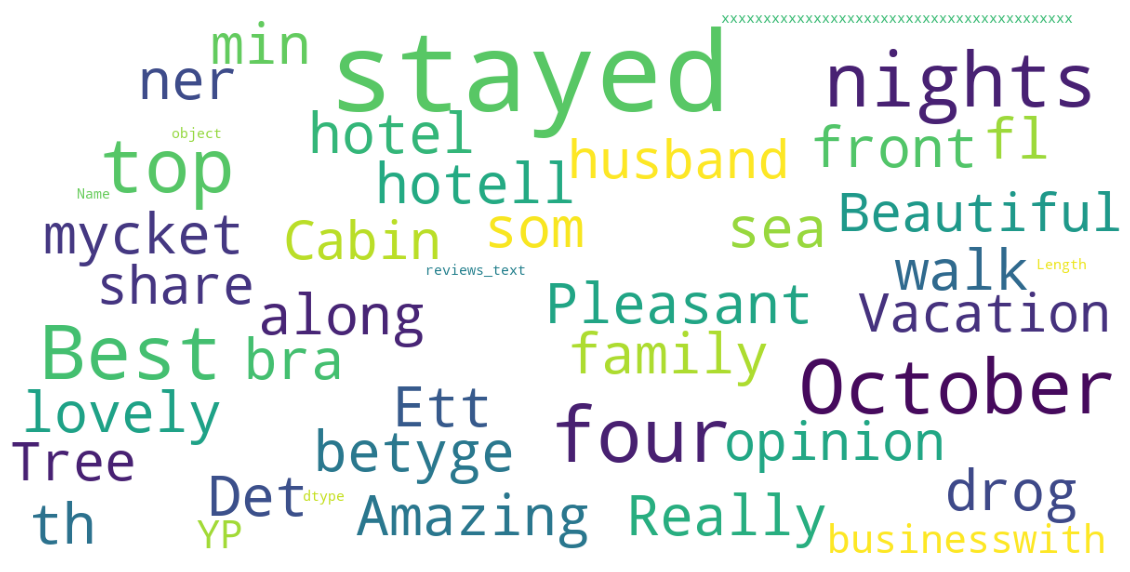

In [42]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(corpus["reviews_text"])

In [43]:
#import text file of stop words, stop words are the most common words in a language that adds no semantics meaning to a sentence
stopwords = set(pd.read_csv('/content/drive/MyDrive/PROYEK/Proyek PBA/stop-word-list.txt', sep='\n', header=0).stopword)

In [44]:
#define a function called process_text to process the text using the methods listed
# case folding
# remove punctuation
# stopword removal
# remove review handle (@username)
# remove website URLs that start with 'https?://'
# remove website URLs that start with 'www.'
# tokenization

def process_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()

    try:
        text = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = souped

    cleaned_text = re.sub(punctuation_handle, " ",(re.sub(www_handle, '', re.sub(combined_handle, '', text)).lower()))
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stopwords])

    return (" ".join([word for word in word_tokenize.tokenize(cleaned_text) if len(word) > 1])).strip()

In [45]:
#test the above text cleaning method
example_text = "Stayed with parents, wife twin toddlers in two triple rooms. The hotel is easy to reach and the rooms were well placed well furnished. The best feature was extremely friendly helpful staff, particularly Ms. Annalucia Ms. Anna who were always ready to listen help out with big smiles. The breakfasts were very good, with good spread and the guests were made welcome to sit and eat at leisure (more important when you are with toddlers!) Would surely go back to Venice would happily stay again at Russo Palace."

process_text(example_text)

'stayed parents wife twin toddlers triple rooms hotel easy reach rooms placed furnished best feature extremely friendly helpful staff particularly ms annalucia ms anna ready listen help big smiles breakfasts good good spread guests welcome sit eat leisure important toddlers surely venice happily stay russo palace'

In [46]:
stop_words = set(pd.read_csv('/content/drive/MyDrive/PROYEK/Proyek PBA/stop-word-list.txt', sep='\n', header=0).stopword)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    return re.sub(r'[^a-z]',' ',text)

def lemmatize(tokens):
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, 'v'), tokens))
    return ' '.join(list(filter(lambda x: not x in stop_words, lemmatized_tokens)))

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    return lemmatize(tokens)

In [47]:
corpus['text'] = corpus['reviews_text'].progress_apply(preprocess)

TypeError: ignored

In [37]:
corpus = corpus.loc[:,['text','sentiment']]
corpus.to_csv('cleaned.csv',sep='|',index=False)
!cp cleaned.csv ./drive/My\ Drive/data
!rm cleaned.csv

KeyError: ignored

#Splitting Train Data

In [ ]:
cleaned_text = []

for text in corpus.reviews_text:
    corpus['reviews_text'].str.len()
    cleaned_text.append(process_text('reviews_text'))

clean_text = pd.DataFrame({'clean_text' : cleaned_text})
corpus = pd.concat([corpus, clean_text], axis = 1)

corpus.sample(5)

In [ ]:
from sklearn.model_selection import train_test_split

attribute = corpus.clean_text
target = corpus.reviews_text

In [ ]:
attribute_train, attribute_test, target_train, target_test = train_test_split(attribute, target, test_size = 0.1, random_state = 225)

print('attribute_train :', len(attribute_train))
print('attribute_test  :', len(attribute_test))
print('target_train :', len(target_train))
print('target_test  :', len(target_test))

#Training

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()


#Classifier using Naive Bayes